In [1]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import numpy as np
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 1
%aimport data_processing
from data_processing import *

Using TensorFlow backend.


In [3]:
#galaxies, data_keys, unit_dict = load_galfiles(redshifts=[0,1,2,5,10,20,30,40,60,80], equal_numbers=False)
galaxies, data_keys, unit_dict = load_single_galfile(redshift=0)
print(data_keys)

shape before modification:  (624645, 20)
shape after removing small galaxies and adding redshift:  (297366, 21)
{'Halo_mass': 0, 'Halo_growth_rate': 1, 'Halo_mass_peak': 2, 'Scale_peak_mass': 3, 'Scale_half_mass': 4, 'Halo_radius': 5, 'Concentration': 6, 'Halo_spin': 7, 'Stellar_mass': 8, 'SFR': 9, 'Intra_cluster_mass': 10, 'Stellar_mass_obs': 11, 'SFR_obs': 12, 'X_pos': 13, 'Y_pos': 14, 'Z_pos': 15, 'X_vel': 16, 'Y_vel': 17, 'Z_vel': 18, 'Type': 19, 'Redshift': 20}


In [4]:
print(np.isnan(galaxies[:, data_keys['Halo_mass']]).any())
print(np.isinf(galaxies[:, data_keys['Halo_mass']]).any())

False
False


In [8]:
features_to_keep = ['Halo_mass', 'Halo_mass_peak', 
                    'Halo_radius', 'Concentration', 'Halo_spin', 'Scale_peak_mass',
                    'Scale_half_mass', 'Type']
norm = 'zero_mean_unit_std' # 'zero_mean_unit_std', 'zero_to_one'
indeces_to_keep = []
for key in features_to_keep:
    indeces_to_keep.append(data_keys[key])
x = galaxies[:, indeces_to_keep]
n_data_points = np.shape(galaxies)[0]

if norm == 'zero_mean_unit_std':
    x_means = np.mean(x, 0)
    x_stds = np.std(x, 0)

    x_norm = (x - x_means) / x_stds
elif norm == 'zero_to_one':
    x_max = np.max(x, 0)
    x_min = np.min(x, 0)
    
    x_norm = (x - x_min) / (x_max - x_min)
else:
    print('Provide a valid norm.')

if np.isnan(x_norm).any():
    print('Some of the values of the normed data is NaN.')
if np.isinf(x_norm).any():
    print('Some of the values of the normed data is Inf.')

<IPython.core.display.Javascript object>


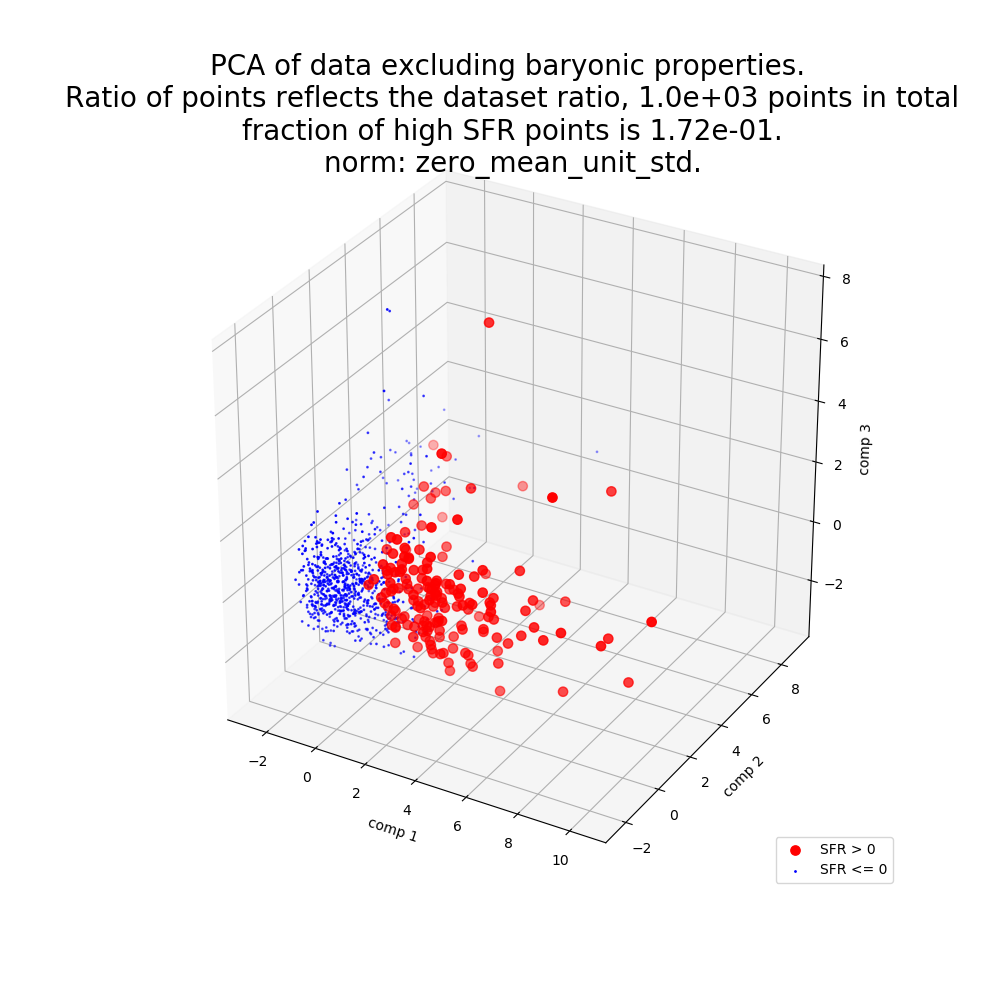

In [48]:
### PCA Plot, assign colors according to SFR
equal_nrs_from_cats = False
tot_nr_points_to_plot = 1000

sfr_cutoff = 0
marker_size = [45, 1]

nr_components = 3
pca = PCA(n_components=nr_components)
pca.fit(x_norm)
x_red = pca.transform(x_norm)

if equal_nrs_from_cats:
    
    n_points_per_cat = int(tot_nr_points_to_plot/2)
    large_sfr_inds = np.where(galaxies[:, data_keys['SFR']] > sfr_cutoff)
    small_sfr_inds = np.where(galaxies[:, data_keys['SFR']] <= sfr_cutoff)
    large_sfr_inds_subset = np.random.choice(large_sfr_inds[0], n_points_per_cat, replace=False)
    small_sfr_inds_subset = np.random.choice(small_sfr_inds[0], n_points_per_cat, replace=False)
    
    title = 'PCA of data excluding baryonic properties. \nEqual nr of points from each category shown (%d).\nnorm: %s.' % \
            (n_points_per_cat, norm)
    
    
    
else:
    
    frac_pts_low_sfr = np.sum(galaxies[:, data_keys['SFR']] <= sfr_cutoff) / n_data_points
    frac_pts_high_sfr = 1 - frac_pts_low_sfr
    nr_pts_low_sfr = int(tot_nr_points_to_plot * frac_pts_low_sfr)
    nr_pts_high_sfr = int(tot_nr_points_to_plot * frac_pts_high_sfr)
    
    large_sfr_inds = np.where(galaxies[:, data_keys['SFR']] > sfr_cutoff)
    small_sfr_inds = np.where(galaxies[:, data_keys['SFR']] <= sfr_cutoff)
    large_sfr_inds_subset = np.random.choice(large_sfr_inds[0], nr_pts_high_sfr, replace=False)
    small_sfr_inds_subset = np.random.choice(small_sfr_inds[0], nr_pts_low_sfr, replace=False)
    
    title = 'PCA of data excluding baryonic properties. \n' + \
            'Ratio of points reflects the dataset ratio, %.1e points in total\nfraction of high SFR points is %.2e.\nnorm: %s.' % \
            (tot_nr_points_to_plot, frac_pts_high_sfr, norm)
    
%matplotlib notebook
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_red[large_sfr_inds_subset,0], x_red[large_sfr_inds_subset,1], 
           x_red[large_sfr_inds_subset,2], c='r', s=marker_size[0])
sc = ax.scatter(x_red[small_sfr_inds_subset,0], x_red[small_sfr_inds_subset,1], 
           x_red[small_sfr_inds_subset,2], c='b', s=marker_size[1])
#plt.colorbar(sc)
plt.legend(['SFR > %d' % (sfr_cutoff), 'SFR <= %d' % (sfr_cutoff)], loc = 'lower right')
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')
plt.title(title, 
          fontsize=20)
plt.show()

<IPython.core.display.Javascript object>


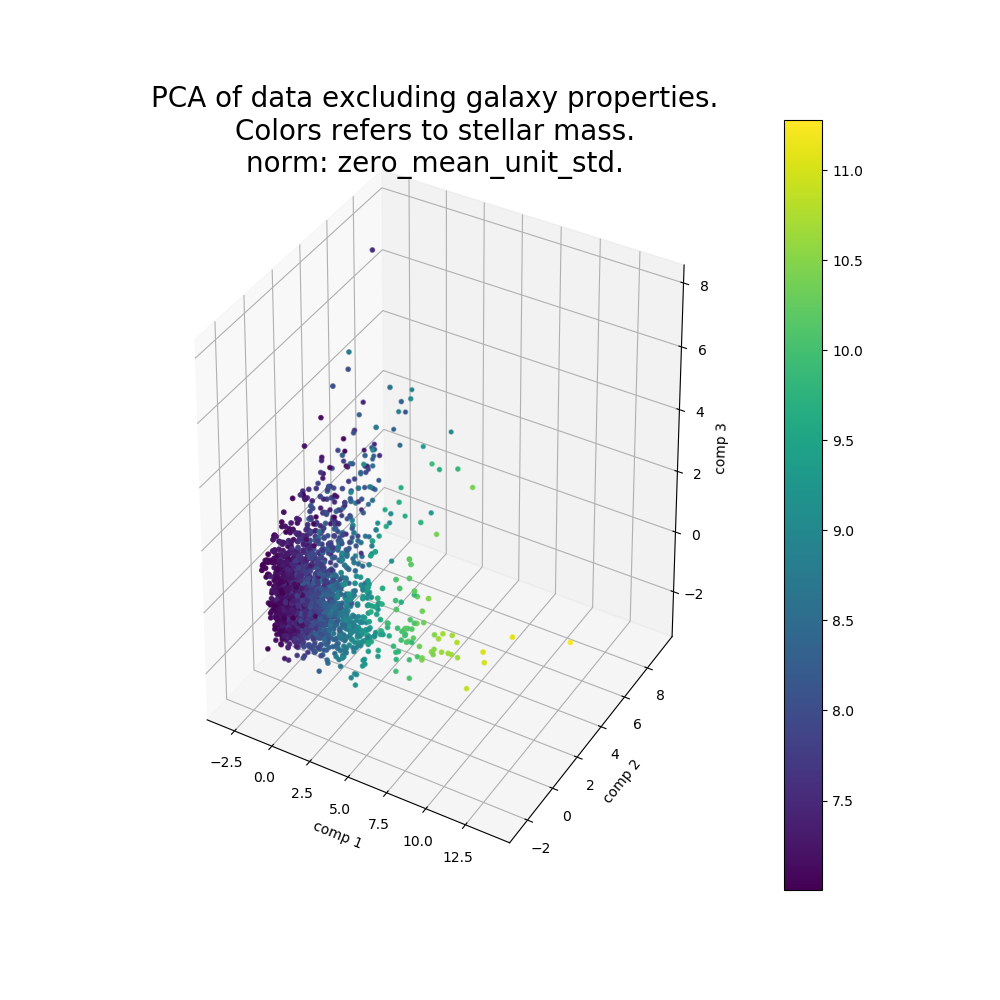

In [49]:
### PCA - Assign colors according to Stellar_mass and size according to SFR
max_size = 500
min_size = 5
n_points_to_show = 2000
colors = galaxies[:, data_keys['Stellar_mass']]
nr_components = 3
pca = PCA(n_components=nr_components)
pca.fit(x_norm)
x_red = pca.transform(x_norm)

%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

subset_indices = np.random.choice(n_data_points, n_points_to_show, replace=False)
fig = plt.figure(1, figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_red[subset_indices,0], x_red[subset_indices,1], 
           x_red[subset_indices,2], c=colors[subset_indices], s=10)
plt.colorbar(sc)
ax.set_xlabel('comp 1')
ax.set_ylabel('comp 2')
ax.set_zlabel('comp 3')
plt.title('PCA of data excluding galaxy properties.\nColors refers to stellar mass.'+
          '\nnorm: %s.' % (norm), 
          fontsize=20)
plt.show()

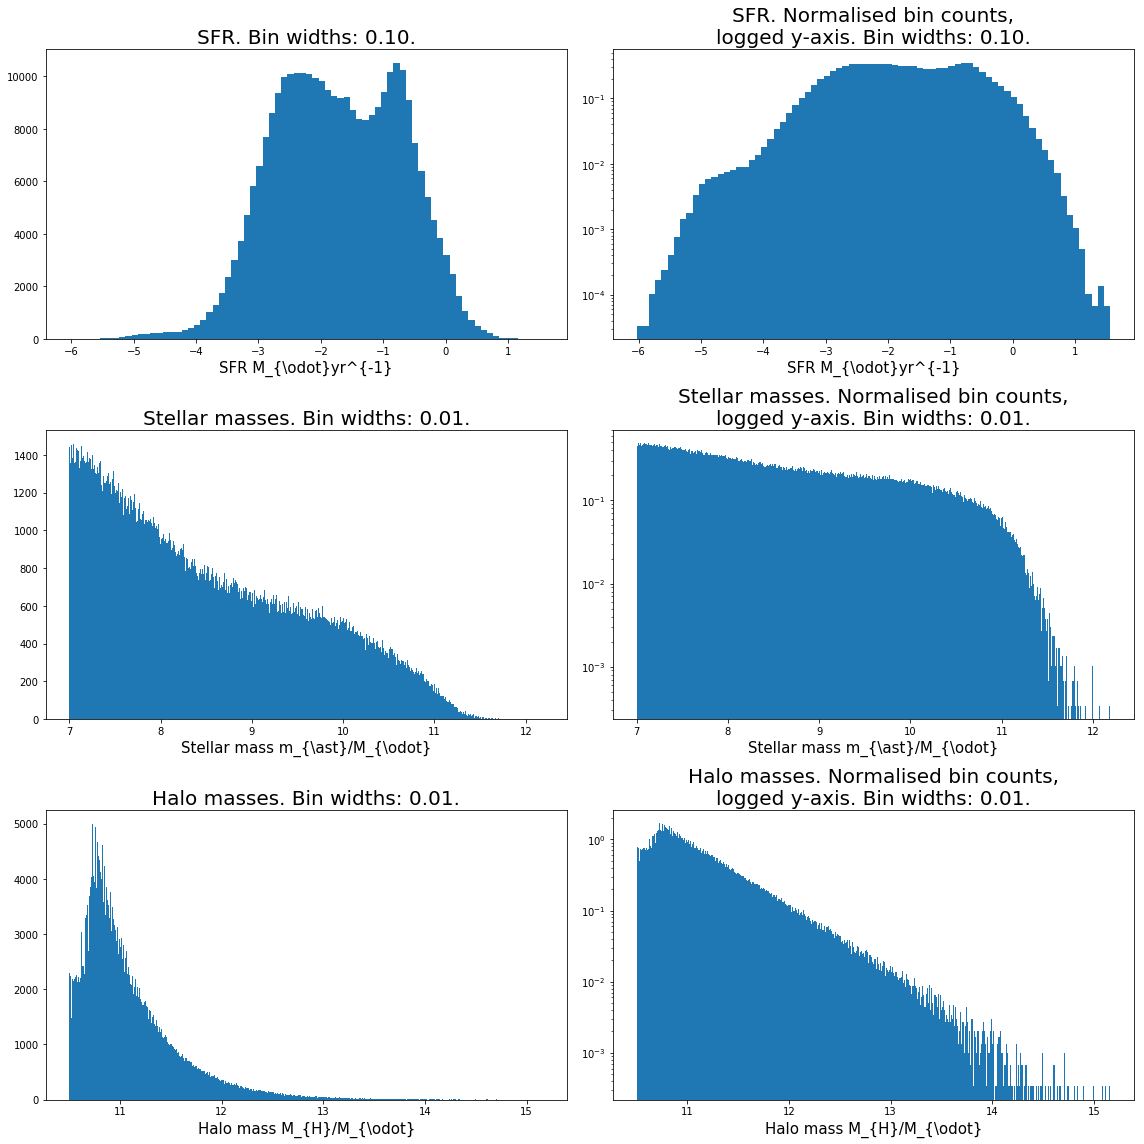

In [9]:
### Histogram over SFR and Stellar mass properties
bin_width_sfr = 0.1
bin_width_stellar_mass = 0.01
bin_width_halo_mass = 0.01

max_sfr = np.max(galaxies[:, data_keys['SFR']])
min_sfr = np.min(galaxies[:, data_keys['SFR']])
bins = np.arange(min_sfr, max_sfr + bin_width_sfr, bin_width_sfr)
%matplotlib inline
fig1 = plt.figure(figsize = (16,16))
ax1 = plt.subplot(321)
plt.hist(galaxies[:, data_keys['SFR']], bins = bins, density = False, label = 'SFR %s' % (unit_dict['SFR']))
plt.title('SFR. Bin widths: %.2f.' % (bin_width_sfr), fontsize=20)
plt.xlabel('SFR '+unit_dict['SFR'], fontsize=15)
ax2 = plt.subplot(322)
plt.hist(galaxies[:, data_keys['SFR']], bins = bins, density = True, log = True)
plt.title('SFR. Normalised bin counts,\nlogged y-axis. Bin widths: %.2f.' % (bin_width_sfr), fontsize=20)
plt.xlabel('SFR '+unit_dict['SFR'], fontsize=15)
#plt.show()

max_stellar_mass = np.max(galaxies[:, data_keys['Stellar_mass']])
min_stellar_mass = np.min(galaxies[:, data_keys['Stellar_mass']])
bins = np.arange(min_stellar_mass, max_stellar_mass + bin_width_stellar_mass, bin_width_stellar_mass)
#%matplotlib inline
#fig2 = plt.figure(figsize = (16,6))
ax1 = plt.subplot(323)
plt.hist(galaxies[:, data_keys['Stellar_mass']], bins = bins, density = False, 
         label = 'Stellar_mass %s' % (unit_dict['Stellar_mass']))
plt.title('Stellar masses. Bin widths: %.2f.' % (bin_width_stellar_mass), fontsize=20)
plt.xlabel('Stellar mass '+unit_dict['Stellar_mass'], fontsize=15)
ax2 = plt.subplot(324)
plt.hist(galaxies[:, data_keys['Stellar_mass']], bins = bins, density = True, log = True)
plt.title('Stellar masses. Normalised bin counts,\nlogged y-axis. Bin widths: %.2f.' % 
          (bin_width_stellar_mass), fontsize=20)
plt.xlabel('Stellar mass '+unit_dict['Stellar_mass'], fontsize=15)
#plt.show()

max_halo_mass = np.max(galaxies[:, data_keys['Halo_mass']])
min_halo_mass = np.min(galaxies[:, data_keys['Halo_mass']])
bins = np.arange(min_halo_mass, max_halo_mass + bin_width_halo_mass, bin_width_halo_mass)
#%matplotlib inline
#fig3 = plt.figure(figsize = (16,6))
ax1 = plt.subplot(325)
plt.hist(galaxies[:, data_keys['Halo_mass']], bins = bins, density = False, 
         label = 'Halo_mass %s' % (unit_dict['Halo_mass']))
plt.title('Halo masses. Bin widths: %.2f.' % (bin_width_halo_mass), fontsize=20)
plt.xlabel('Halo mass '+unit_dict['Halo_mass'], fontsize=15)
ax2 = plt.subplot(326)
plt.hist(galaxies[:, data_keys['Halo_mass']], bins = bins, density = True, log = True)
plt.title('Halo masses. Normalised bin counts,\nlogged y-axis. Bin widths: %.2f.' % 
          (bin_width_halo_mass), fontsize=20)
plt.xlabel('Halo mass '+unit_dict['Halo_mass'], fontsize=15)
plt.tight_layout()
plt.show()

In [12]:
### Save the figures
fig1.savefig(fig_dir + 'data_analysis_2018-06-04.png', bbox_inches = 'tight')

90% of the data is represented by the first 5 singular values.
These account for 50% of the dimensionality of the current dataset.
norm: zero_to_one.


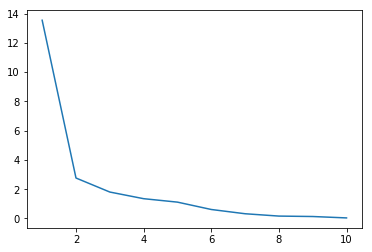

In [10]:
### SVD
u, sing_values, vh = np.linalg.svd(x_norm[:100, :])

%matplotlib inline
plt.plot(range(1,len(sing_values)+1), sing_values)

sing_val_sum = 0

for i in range(len(sing_values)):
    sing_val_sum += sing_values[i]
    if sing_val_sum > .9* np.sum(sing_values):
        print('90%% of the data is represented by the first %d singular values.\n' % (i+1) +
             'These account for %.0f%% of the dimensionality of the current dataset.\n' % (100*(i+1)/len(sing_values))+
             'norm: %s.' % (norm))
        break

In [48]:
print(np.amax(galaxies[:, data_keys['SFR']]))

36.71669387817383


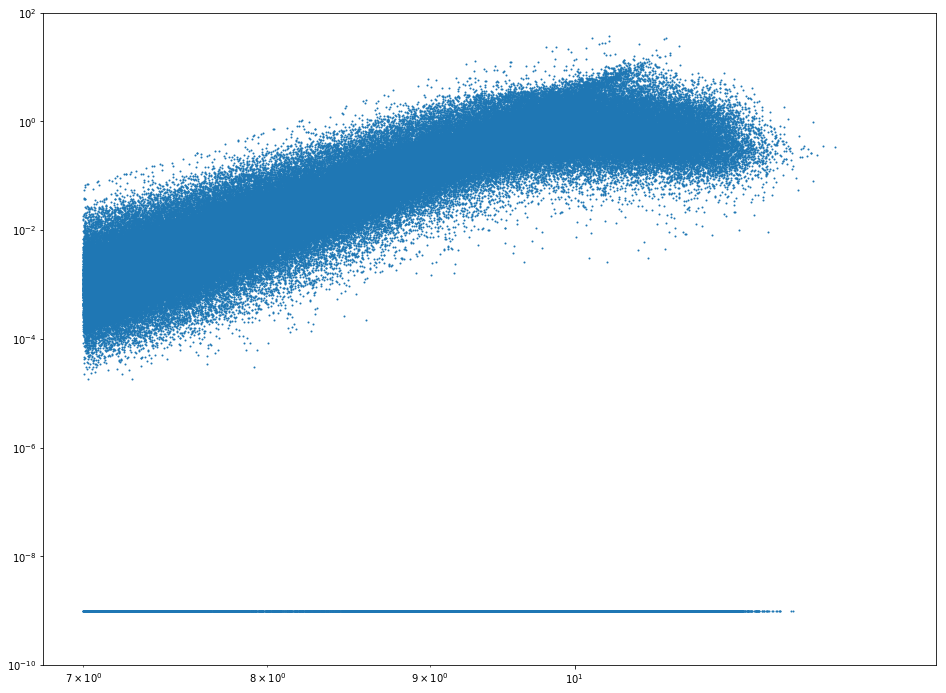

In [61]:
sfr = galaxies[:, data_keys['SFR']]
sfr[sfr == 0] = 1e-9
gals = galaxies[:, data_keys['Stellar_mass']]

%matplotlib inline
fig = plt.figure(figsize = (16,12))
plt.scatter(gals, sfr, s=1)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom=1e-10, top=100)
ax.set_xlim(left=6.8, right=13)
plt.show()

In [62]:
fig.savefig(fig_dir + 'sfr_stellar_mass_scatter.png', bbox_inches = 'tight')